<b style="color: red;">TODO </b>
1) Add signatures from dataset1 to dataset2 mainly related to background color <br>
2) Understand how to setup tensorflow GPU. Currently using Tensorflow CPU

<p style="color: red;">
Tensor flow install error

  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
ERROR: catboost 0.24.4 requires plotly, which is not installed.
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
Installing collected packages: six, absl-py, gast, grpcio, numpy, oauthlib, requests-oauthlib, rsa, cachetools, google-auth, google-auth-oauthlib, tensorboard-plugin-wit, wheel, tensorboard, wrapt, typing-extensions, keras-preprocessing, astunparse, opt-einsum, tensorflow-estimator, flatbuffers, tensorflow-cpu
  Attempting uninstall: six

</p>

<b>Tuning </b><p>
To try
* _compute_loss_sq change margin from 0.0 to 0.1   8/3 - Trying (need to retrain)
* Use the same loss function in test as used in training.  8/3 - Trying
* Try MXNet is faster than tensorflow.

* Add a custom layer which included the forgery decision to determine the weights (maybe use a MixMaxScaler to maximize the diff range)
* Recalculate all the weights for ResNet50
* Try a VGG16 with triplet loss mining.
* Build a custom layers



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications  ##Tensor flow version used 2.4.1
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [4]:
imageDimensions = (224,224,3)

<b>Utility functions</b>

In [5]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, imageDimensions[:-1])
    return image

In [6]:
def preprocess_triplets_train( anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    print(">>> Anchor", anchor)

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [7]:
def preprocess_triplets(personId, anchor, positive, negative, isGenuine, anchor_path, positive_path, negative_path):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    print(">>> Anchor", anchor)

    return (
        personId,
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
        isGenuine,
        anchor_path, positive_path, negative_path
    )

In [8]:
# *****OLD CODE
# def triplet_loss(y_true, y_pred):
#     alpha = 0.5
#     anchor, positive, negative =y_pred[0,0:512], y_pred[0,512:1024], y_pred[0,1024:1536]
    
#     positive_distance = K.mean(K.square(anchor - positive),axis=-1)
#     negative_distance = K.mean(K.square(anchor - negative),axis=-1)
#     return K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))

In [9]:
# *****OLD CODE

# def getImage(basePath, typeOfData, dfRec, imageDimensions):
#     img_path = basePath + "/" + typeOfData + "/" + dfRec["relPath"] + "/" + dfRec["fileName"]
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (imageDimensions[1],imageDimensions[0]), interpolation=cv2.INTER_CUBIC)
#     #img = img/255 - resulted in a drop in accuracy
#     #preprocess_input(img)
#     return img;

In [10]:
def visualize(images_dataset):
    """Visualize a few triplets from the supplied batches."""

    def showImages(ax, image):
        for i in range(3):
            ax[i].imshow(image[i])
            ax[i].get_xaxis().set_visible(False)
            ax[i].get_yaxis().set_visible(False)

    rows = len(images_dataset)
    images = list(images_dataset.as_numpy_iterator())
    fig, axs = plt.subplots(rows,3, sharex=True, sharey=True, figsize=(500,500))
    for x in range(rows):
         anchor, positive, negative = images[x][0],images[x][1],images[x][2]
         showImages(axs[x], (anchor, positive, negative))


<b> Load training and test data </b>

In [11]:
basePath = "/notebooks/capstone/dataset/dataset2/sign_data"
data_train = pd.read_csv(basePath + "/train/train_clean.csv")
data_train.sort_values(by="personId", inplace=True)
print(data_train.head())
print(data_train.shape)

       company  personId person        fileName   relPath  Genuine  forged
0    Acme Corp         1   Erin      001_01.PNG       001        1       0
887  Acme Corp         1   Erin  0119001_01.png  001_forg        0       1
894  Acme Corp         1   Erin  0201001_04.png  001_forg        0       1
888  Acme Corp         1   Erin  0119001_02.png  001_forg        0       1
889  Acme Corp         1   Erin  0119001_03.png  001_forg        0       1
(1649, 7)


In [12]:
data_test = pd.read_csv(basePath + "/test/test_clean.csv")
data_test.sort_values(by="personId", inplace=True)
print(data_test.head(20))
print(data_test.shape)

           company  personId person        fileName   relPath  Genuine  forged
0    AI Novice Inc        49     IE      01_049.png       049        1       0
255  AI Novice Inc        49     IE  02_0114049.PNG  049_forg        0       1
256  AI Novice Inc        49     IE  02_0206049.PNG  049_forg        0       1
257  AI Novice Inc        49     IE  02_0210049.PNG  049_forg        0       1
252  AI Novice Inc        49     IE  01_0114049.PNG  049_forg        0       1
258  AI Novice Inc        49     IE  03_0114049.PNG  049_forg        0       1
259  AI Novice Inc        49     IE  03_0206049.PNG  049_forg        0       1
260  AI Novice Inc        49     IE  03_0210049.PNG  049_forg        0       1
261  AI Novice Inc        49     IE  04_0114049.PNG  049_forg        0       1
262  AI Novice Inc        49     IE  04_0206049.PNG  049_forg        0       1
263  AI Novice Inc        49     IE  04_0210049.PNG  049_forg        0       1
254  AI Novice Inc        49     IE  01_0210049.PNG 

<b>Prepare training data</b>

In [13]:
def categorizeImages(df, typeOfData):
    personIds = df["personId"].unique()
    anchor_imgs = []
    postive_imgs = []
    negative_imgs = []
    for p in personIds:
        genuine = df[(df.personId==p) & (df.Genuine==1)]
        forg = df[(df.personId==p) & (df.Genuine==0)]
        anchor_img = basePath+"/"+typeOfData+"/"+genuine.iloc[0].relPath + "/"+genuine.iloc[0].fileName  
        for g in genuine[1:].index:
            pos_img= basePath+"/"+typeOfData+"/"+genuine.loc[g].relPath + "/"+genuine.loc[g].fileName  
            for f in forg.index:
                neg_img =  basePath+"/"+typeOfData+"/"+forg.loc[f].relPath + "/"+forg.loc[f].fileName  
                anchor_imgs.append(anchor_img)
                postive_imgs.append(pos_img)
                negative_imgs.append(neg_img)
    
    return anchor_imgs,postive_imgs,negative_imgs

In [14]:
anchor_images,positive_images,negative_images = categorizeImages(data_train, "train")

In [15]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset  = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset  = tf.data.Dataset.from_tensor_slices(negative_images)
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets_train)


>>> Anchor Tensor("args_0:0", shape=(), dtype=string)


In [16]:
# Let's now split our dataset in train and validation.
image_count = len(anchor_dataset)
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

In [17]:
#visualize(train_dataset.take(5))

In [18]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

<b>Define Evaluation Functions</b>

In [19]:
#Compare each positive each positive in the set and and each negative against all other positives
def categorizeTestImages(df, typeOfData):
    personIds = df["personId"].unique()
    anchor_imgs = []
    postive_imgs = []
    toCompare_imgs = []
    isGenuine = []
    personId = []
    for p in personIds:
        genuine = df[(df.personId==p) & (df.Genuine==1)]
        forg = df[(df.personId==p) & (df.Genuine==0)]
        anchor_img = basePath+"/"+typeOfData+"/"+genuine.iloc[0].relPath + "/"+genuine.iloc[0].fileName  
        for g in genuine[1:].index:
            pos_img= basePath+"/"+typeOfData+"/"+genuine.loc[g].relPath + "/"+genuine.loc[g].fileName  
            #Compare this with all forgeries
            for f in forg.index:
                toCompareImg =  basePath+"/"+typeOfData+"/"+forg.loc[f].relPath + "/"+forg.loc[f].fileName 
                personId.append(p)
                anchor_imgs.append(anchor_img)
                postive_imgs.append(pos_img)
                toCompare_imgs.append(toCompareImg)
                isGenuine.append(False)
                
            # Compare current postive with all other positives besides the anchor
            for f in genuine[1:].index:
                toCompareImg =  basePath+"/"+typeOfData+"/"+genuine.loc[f].relPath + "/"+genuine.loc[f].fileName  
                if ( pos_img != toCompareImg):
                    personId.append(p)
                    anchor_imgs.append(anchor_img)
                    postive_imgs.append(pos_img)
                    toCompare_imgs.append(toCompareImg)
                    isGenuine.append(True)    
    return personId, anchor_imgs,postive_imgs,toCompare_imgs, isGenuine

In [20]:
# ** OLD CODE **
# tst_personId, tst_anchor_images,tst_positive_images,tst_toCompare_imgs, tst_isGenuine = categorizeTestImages(data_test, "test")

In [21]:
# ** OLD CODE **
# print(len(tst_personId))
# print(len(tst_anchor_images))
# print(len(tst_positive_images))
# print(len(tst_toCompare_imgs))
# print(len(tst_isGenuine))

In [22]:
# ** OLD CODE **
# tst_personId_dataset = tf.data.Dataset.from_tensor_slices(tst_personId)
# tst_anchor_dataset = tf.data.Dataset.from_tensor_slices(tst_anchor_images)
# tst_positive_dataset  = tf.data.Dataset.from_tensor_slices(tst_positive_images)
# tst_toCompare_imgs_dataset  = tf.data.Dataset.from_tensor_slices(tst_toCompare_imgs)
# tst_isGenuine_dataset  = tf.data.Dataset.from_tensor_slices(tst_isGenuine)

# tst_anchor_path_dataset = tf.data.Dataset.from_tensor_slices(tst_anchor_images)
# tst_positive_path_dataset  = tf.data.Dataset.from_tensor_slices(tst_positive_images)
# tst_toCompare_imgs_path_dataset  = tf.data.Dataset.from_tensor_slices(tst_toCompare_imgs)

# tst_dataset = tf.data.Dataset.zip((tst_personId_dataset, tst_anchor_dataset, tst_positive_dataset, tst_toCompare_imgs_dataset, tst_isGenuine_dataset, tst_anchor_path_dataset, tst_positive_path_dataset, tst_toCompare_imgs_path_dataset))
# tst_dataset = tst_dataset.map(preprocess_triplets)
# len(tst_dataset)

In [23]:
#visualize(tst_dataset.take(5))


In [24]:
def prepareEvaluationData(data_df, typeOfData):
    personId, anchor_images,positive_images,toCompare_imgs, isGenuine = categorizeTestImages(data_df, typeOfData)
    personId_dataset = tf.data.Dataset.from_tensor_slices(personId)
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset  = tf.data.Dataset.from_tensor_slices(positive_images)
    toCompare_imgs_dataset  = tf.data.Dataset.from_tensor_slices(toCompare_imgs)
    isGenuine_dataset  = tf.data.Dataset.from_tensor_slices(isGenuine)

    anchor_path_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_path_dataset  = tf.data.Dataset.from_tensor_slices(positive_images)
    toCompare_imgs_path_dataset  = tf.data.Dataset.from_tensor_slices(toCompare_imgs)

    dataset = tf.data.Dataset.zip((personId_dataset, anchor_dataset, positive_dataset, toCompare_imgs_dataset, isGenuine_dataset, anchor_path_dataset, positive_path_dataset, toCompare_imgs_path_dataset))
    ##dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_triplets)
    
    return dataset

<b>Prepare Model Architecture</b>
Setting up the embedding generator model

In [25]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=imageDimensions, include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":     ##TODO: Why only this layer?
#         trainable = True
    layer.trainable = trainable

In [26]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

<B>Setting up the Siamese Network model</B>

In [27]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=imageDimensions)
positive_input = layers.Input(name="positive", shape=imageDimensions)
negative_input = layers.Input(name="negative", shape=imageDimensions)

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),   ##TODO : What is pre-process input do here?
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances  ##TODO: Not clear what Output does here?
)

<b> Train Model - To Generate Embedding </b>
<p>We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.</p>

In [28]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

         
    def _compute_loss_sq(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.1)
        return loss
    
#     def _compute_loss_cos(self, data):
#         cosine_similarity = metrics.CosineSimilarity()
#         sitive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
#         print("Positive similarity:", positive_similarity)
#         negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
#         print("Negative similarity", negative_similarity)
#         loss = tf.math.squared_difference(positive_similarity, negative_similarity)
#         loss = tf.maximum(loss + self.margin, 0.0)
#         #tf.math.squared_difference
#         return loss

    def _compute_loss(self, data):
        return self._compute_loss_sq(data)
    
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0000001))
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=early_stop)

#Tuning
# Image dimension=448, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=2.1
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=0.05
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, lossFn=cos, loss=? 
# Image dimension=224, margin=10 epoch 1, norestraining of weights,Adam=0.0001, loss=0.5
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights, Adam=0.00001 instead of 0.0001 loss=?**  0.000001 - 0.0020 - val_loss: 0.0095
# Image dimension=112, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=0.17

Epoch 1/20
247/247 [==============================] - 240s 928ms/step - loss: 0.1210 - val_loss: 0.0486
Epoch 2/20
247/247 [==============================] - 224s 908ms/step - loss: 0.0963 - val_loss: 0.0425
Epoch 3/20
247/247 [==============================] - 224s 907ms/step - loss: 0.0785 - val_loss: 0.0367
Epoch 4/20
247/247 [==============================] - 225s 912ms/step - loss: 0.0655 - val_loss: 0.0439
Epoch 5/20
247/247 [==============================] - 224s 907ms/step - loss: 0.0556 - val_loss: 0.0321
Epoch 6/20
247/247 [==============================] - 226s 914ms/step - loss: 0.0466 - val_loss: 0.0333
Epoch 7/20
247/247 [==============================] - 225s 913ms/step - loss: 0.0396 - val_loss: 0.0359
Epoch 8/20
247/247 [==============================] - 224s 907ms/step - loss: 0.0342 - val_loss: 0.0319
Epoch 9/20
247/247 [==============================] - 225s 912ms/step - loss: 0.0308 - val_loss: 0.0316
Epoch 10/20
247/247 [==============================] - 227s 918m

In [25]:
filename = '/notebooks/capstone/models/embeddings-res32'
filename2 = '/notebooks/capstone/models/siamesenetwork-res32'

In [31]:
#embedding.save(filename)
#siamese_network.save(filename2)

INFO:tensorflow:Assets written to: /notebooks/capstone/models/embeddings-res32/assets
INFO:tensorflow:Assets written to: /notebooks/capstone/models/siamesenetwork-res32/assets


In [ ]:
siamese_network = tf.keras.models.load_model(filename2)

<b>Train Decision Model</b>

In [26]:
def getEmbeddings(row):
    personId, anchor, positive, toCcompare, isGenuine, anchor_path, positive_path, toCcompare_path = row
    return (
        personId.numpy(), 
        embedding(resnet.preprocess_input(anchor)),
        embedding(resnet.preprocess_input(positive)),
        embedding(resnet.preprocess_input(toCcompare)),
        isGenuine.numpy()
        ,anchor_path.numpy()
        ,positive_path.numpy()
        ,toCcompare_path.numpy()
    )

In [27]:
def getEmbeddingDataFrame(data_df, typeOfData):
    dataset = prepareEvaluationData(data_df, typeOfData)
    dataset = dataset.batch(1, drop_remainder=False)
    embedding_data = [getEmbeddings(row) for row in iter(dataset)]
    embeddings_data_df = pd.DataFrame(columns=["personId", "anchor_embedding", "positive_embedding","negative_embedding","isGenuine", "Anchor_Path", "Pos_Path", "ToComparePath"], data=embedding_data)
    return embeddings_data_df

In [28]:
def compareEmbeds_row_cosine (personId, anchor_embedding, positive_embedding, negative_embedding, isGenuine):
    cosine_similarity = metrics.CosineSimilarity()

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    #print("Positive similarity:", positive_similarity.numpy())

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    #print("Negative similarity", negative_similarity.numpy())
    return (positive_similarity.numpy(), negative_similarity.numpy(), (positive_similarity.numpy() - negative_similarity.numpy()))

def compareEmbeds_row_kMeansdistance (personId, anchor_embedding, positive_embedding, negative_embedding, isGenuine):
        ap_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), -1)
        an_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), -1)
        return (ap_distance, an_distance, (ap_distance-an_distance))

def compareEmbeds(df):
    df2 = df.apply(lambda row: compareEmbeds_row_kMeansdistance(row.personId, row.anchor_embedding, row.positive_embedding, row.negative_embedding, row.isGenuine), axis=1,  result_type='expand')
    df2.columns = ["Pos", "Neg", "Diff"]

    df[["Pos", "Neg", "Diff"]]=df2[["Pos", "Neg", "Diff"]]
    df["personId"]=df["personId"].apply(lambda x: x[0])
    df["isGenuine"]=df["isGenuine"].apply(lambda x: x[0])
    
    return df

In [29]:
##Load model
embedding = tf.keras.models.load_model(filename)

In [ ]:
embeddings_data_df_train = getEmbeddingDataFrame(data_train, "train")
embeddings_data_df_train.head(1)

In [24]:
import pickle
#pFile_embeddings_train = "/notebooks/capstone/train_embeddings.pickle"  ##cosine
pFile_embeddings_train = "/notebooks/capstone/train_embeddings_k.pickle"  ##kmean distance

In [25]:
with open(pFile_embeddings_train, 'wb') as file:
    pickle.dump(embeddings_data_df_train, file)

In [26]:
with open(pFile_embeddings_train, 'rb') as file:
    df = pickle.load(file)
df.shape

(20798, 8)

In [27]:
# Compare embedding with the anchor
df = compareEmbeds(df)
df.head(3)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
0,1,"((tf.Tensor(0.5121779, shape=(), dtype=float32...","((tf.Tensor(0.5782136, shape=(), dtype=float32...","((tf.Tensor(0.61071765, shape=(), dtype=float3...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.8254158, shape=(), dtype=float32))","(tf.Tensor(3.9730136, shape=(), dtype=float32))","(tf.Tensor(-2.1475978, shape=(), dtype=float32))"
1,1,"((tf.Tensor(0.5121779, shape=(), dtype=float32...","((tf.Tensor(0.5782136, shape=(), dtype=float32...","((tf.Tensor(0.5373855, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.8254158, shape=(), dtype=float32))","(tf.Tensor(4.8498363, shape=(), dtype=float32))","(tf.Tensor(-3.0244205, shape=(), dtype=float32))"
2,1,"((tf.Tensor(0.5121779, shape=(), dtype=float32...","((tf.Tensor(0.5782136, shape=(), dtype=float32...","((tf.Tensor(0.6378917, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.8254158, shape=(), dtype=float32))","(tf.Tensor(3.3919668, shape=(), dtype=float32))","(tf.Tensor(-1.566551, shape=(), dtype=float32))"


In [52]:
# Setup a logistic regression model for predictions
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(df[["personId", "Pos", "Neg"]], df["isGenuine"])

NameError: name 'df' is not defined

In [38]:
#pFile_lrmodel = "/notebooks/capstone/train_embeddings.pickle" #cosine
pFile_lrmodel = "/notebooks/capstone/train_embeddings_k.pickle"  #kmeans

In [30]:
with open(pFile_lrmodel, 'wb') as file:
    pickle.dump(lr, file)

In [39]:
with open(pFile_lrmodel, 'rb') as file:
    lr = pickle.load(file)

In [32]:
y_train_predict = lr.predict(df[["personId", "Pos", "Neg"]])  #neg = tocompare

In [33]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df["isGenuine"], y_train_predict, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan

In [34]:
metrics.confusion_matrix(df["isGenuine"], y_train_predict)

array([[ 8716,  1126],
       [  716, 10240]])

<b>Testing</b>

Inspecting what the network has learned
At this point, we can check how the network learned to separate the embeddings depending on whether they belong to similar images.

We can use cosine similarity to measure the similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the embeddings generated for each image.

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [31]:
embeddings_data_df_tst = getEmbeddingDataFrame(data_test, "test")
embeddings_data_df_tst.head(1)

>>> Anchor Tensor("args_1:0", shape=(), dtype=string)


,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath
0,[49],"((tf.Tensor(0.5426802, shape=(), dtype=float32...","((tf.Tensor(0.42531887, shape=(), dtype=float3...","((tf.Tensor(0.6553408, shape=(), dtype=float32...",[False],[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...


In [30]:
pFile_embeddings_tst = "/notebooks/capstone/tst_embeddings_k.pickle"

In [32]:
import pickle
with open(pFile_embeddings_tst, 'wb') as file:
    pickle.dump(embeddings_data_df_tst, file)

In [33]:
with open(pFile_embeddings_tst, 'rb') as file:
    df_tst = pickle.load(file)
df_tst.shape

(5038, 8)

In [34]:
df_tst = compareEmbeds(df_tst)
df_tst.head(3)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
0,49,"((tf.Tensor(0.5426802, shape=(), dtype=float32...","((tf.Tensor(0.42531887, shape=(), dtype=float3...","((tf.Tensor(0.6553408, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.3991302, shape=(), dtype=float32))","(tf.Tensor(11.180908, shape=(), dtype=float32))","(tf.Tensor(-9.781778, shape=(), dtype=float32))"
1,49,"((tf.Tensor(0.5426802, shape=(), dtype=float32...","((tf.Tensor(0.42531887, shape=(), dtype=float3...","((tf.Tensor(0.7207364, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.3991302, shape=(), dtype=float32))","(tf.Tensor(1.7702737, shape=(), dtype=float32))","(tf.Tensor(-0.37114346, shape=(), dtype=float32))"
2,49,"((tf.Tensor(0.5426802, shape=(), dtype=float32...","((tf.Tensor(0.42531887, shape=(), dtype=float3...","((tf.Tensor(0.5897555, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,"(tf.Tensor(1.3991302, shape=(), dtype=float32))","(tf.Tensor(5.0825996, shape=(), dtype=float32))","(tf.Tensor(-3.6834693, shape=(), dtype=float32))"


In [40]:
y_tst_predict = lr.predict(df_tst[["personId", "Pos", "Neg"]])  #neg = tocompare

In [43]:
from sklearn import metrics
fpr_tst, tpr_tst, thresholds_tst = metrics.roc_curve(df_tst["isGenuine"], y_tst_predict, pos_label=2)
metrics.auc(fpr_tst, tpr_tst)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan

In [44]:
metrics.confusion_matrix(df_tst["isGenuine"], y_tst_predict)

array([[2254,  474],
       [ 214, 2096]])

In [47]:
lr.score(df_tst[["personId", "Pos", "Neg"]],y_tst_predict )

1.0

In [51]:
metrics.recall_score(df_tst[["personId", "Pos", "Neg"]],y_tst_predict)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

<b> Old code to remove </b>

In [34]:
tst_dataset = tst_dataset.batch(1, drop_remainder=False)

In [35]:
tst_dataset

<BatchDataset shapes: ((None,), (None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3), (None,), (None,), (None,), (None,)), types: (tf.int32, tf.float32, tf.float32, tf.float32, tf.bool, tf.string, tf.string, tf.string)>

In [36]:
sample = next(iter(tst_dataset))
personId, anchor, positive, toCompare, isGenuine, anchor_path, positive_path, toCompare_path = sample
print(f"PersonId: %s anchor: %d positive: %d toCompare: %d isGenuine %s" % (personId.numpy(), len(anchor), len(positive), len(toCompare),isGenuine.numpy()))


PersonId: [49] anchor: 1 positive: 1 toCompare: 1 isGenuine [False]


In [37]:
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(toCompare))
)

In [38]:
print(f"PersonId: %d anchor: %d positive: %d toCompare: %d isGenuine %d" % (len(personId), len(anchor), len(positive), len(toCompare),len(isGenuine)))

PersonId: 1 anchor: 1 positive: 1 toCompare: 1 isGenuine 1


Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [40]:
print (compareEmbeds(personId,anchor_embedding, positive_embedding, negative_embedding, isGenuine))

(array([49], dtype=int32), 0.99485135, 0.97672117, 0.018130183, array([False]))


In [42]:
## Save the embeddings
tst_embedding_data = [getEmbeddings(row) for row in iter(tst_dataset)]
tst_data_embeddings_df = pd.DataFrame(columns=["personId", "anchor_embedding", "positive_embedding","negative_embedding","isGenuine", "Anchor_Path", "Pos_Path", "ToComparePath"], data=tst_embedding_data)
tst_data_embeddings_df.head(1)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath
0,[49],"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.6553377, shape=(), dtype=float32...",[False],[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...


In [43]:
import pickle
pFile_embeddings = "/notebooks/capstone/results_embeddings.pickle"

In [44]:
with open(pFile_embeddings, 'wb') as file:
    pickle.dump(tst_data_embeddings_df, file)

In [45]:
with open(pFile_embeddings, 'rb') as file:
    df = pickle.load(file)
df.shape

(5038, 8)

In [46]:
df.columns

Index(['personId', 'anchor_embedding', 'positive_embedding',
       'negative_embedding', 'isGenuine', 'Anchor_Path', 'Pos_Path',
       'ToComparePath'],
      dtype='object')

<b>Approach 1</b>: Compare the relative distance of positive and negative related to Anchor

In [48]:
df2 = df.apply(lambda row: compareEmbeds(row.personId, row.anchor_embedding, row.positive_embedding, row.negative_embedding, row.isGenuine), axis=1,  result_type='expand')
df2.columns = ["Pos", "Neg", "Diff"]
df2.head(3)

,Pos,Neg,Diff
0,0.994851,0.976721,0.018130
1,0.994851,0.994128,0.000723
2,0.994851,0.987881,0.006971


In [49]:
df[["Pos", "Neg", "Diff"]]=df2[["Pos", "Neg", "Diff"]]
df["personId"]=df["personId"].apply(lambda x: x[0])
df["isGenuine"]=df["isGenuine"].apply(lambda x: x[0])
df.head(3)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
0,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.6553377, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.976721,0.018130
1,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.7207349, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.994128,0.000723
2,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.58976376, shape=(), dtype=float3...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.987881,0.006971


In [50]:
pFile = "/notebooks/capstone/results_approach1.pickle"

In [51]:
with open(pFile, 'wb') as file:
     pickle.dump(df, file)

In [52]:
with open(pFile, 'rb') as file:
     df = pickle.load(file)

df.shape
df.head()

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
0,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.6553377, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.976721,0.018130
1,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.7207349, shape=(), dtype=float32...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.994128,0.000723
2,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.58976376, shape=(), dtype=float3...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.987881,0.006971
3,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.74497586, shape=(), dtype=float3...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.981951,0.012900
4,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.50403637, shape=(), dtype=float3...",False,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.981849,0.013002


In [53]:
df["isGenuine"] = df["isGenuine"].map(lambda x: 1 if x else 0)
df.head()

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
0,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.6553377, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.976721,0.018130
1,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.7207349, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.994128,0.000723
2,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.58976376, shape=(), dtype=float3...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.987881,0.006971
3,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.74497586, shape=(), dtype=float3...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.981951,0.012900
4,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.50403637, shape=(), dtype=float3...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.981849,0.013002


In [54]:
df2 = df[["Diff","isGenuine"]]
df2["Diff"] = df2["Diff"]*10
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Diff,isGenuine
0,0.181302,0
1,0.007232,0
2,0.069706,0
3,0.129004,0
4,0.130024,0


In [55]:
df3_f = df2[(df2.isGenuine == 0)]  # & (df2.Diff < threshold)
df3_g = df2[(df2.isGenuine == 1)]

In [56]:
df3_g.head()

,Diff,isGenuine
12,-0.004438,1
13,-0.000964,1
14,0.005600,1
15,-0.000856,1
16,0.005271,1


(array([  2.,  38., 120., 347., 648., 648., 347., 120.,  38.,   2.]),
 array([-0.03617704, -0.02894163, -0.02170622, -0.01447082, -0.00723541,
         0.        ,  0.00723541,  0.01447082,  0.02170622,  0.02894163,
         0.03617704]),
 <BarContainer object of 10 artists>)

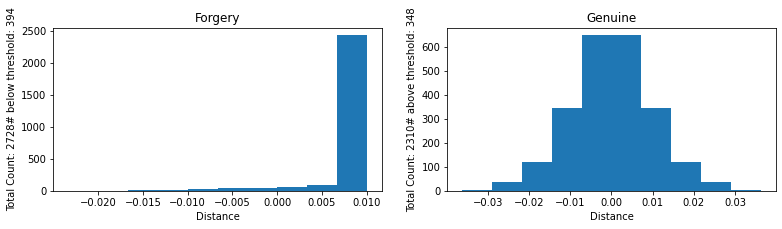

In [57]:
threshold = 0.01

df4_f = df3_f.copy(deep=True)
df4_f["Diff"] = df4_f["Diff"].map(lambda x: x if  x < threshold else threshold)

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.title('Forgery')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df4_f)) + "# below threshold: " + str(len(df3_f[df4_f.Diff < threshold ])))
plt.hist(df4_f["Diff"])

# df3_g = df2[df2.isGenuine==1]["Diff"]*10  #*0.0001
# df4_g = [(d if d < threshold else threshold) for d in df3_g]#0.0000006]

plt.subplot(132)
plt.title('Genuine')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_g)) + "# above threshold: " + str(len(df3_g[df3_g.Diff > threshold ])))
plt.hist(df3_g["Diff"])

In [58]:
df2["Forgery"] =  [1 if d==0 else 0 for d in df2["isGenuine"].values]
df2.corr() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Diff,isGenuine,Forgery
Diff,1.000000,-0.570392,0.570392
isGenuine,-0.570392,1.000000,-1.000000
Forgery,0.570392,-1.000000,1.000000


In [59]:
#All forgeries with a distance < 0
df[(df.Diff < 0) & (df.isGenuine ==0)].head(10)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
8,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.6271175, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.995038,-0.000187
52,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.4241791, shape=(), dtype=float32...","((tf.Tensor(0.6271175, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995044,0.995135,-0.000091
71,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.55992514, shape=(), dtype=float3...","((tf.Tensor(0.6198189, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993731,0.994099,-0.000367
74,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.55992514, shape=(), dtype=float3...","((tf.Tensor(0.6271175, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993731,0.994478,-0.000747
77,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.55992514, shape=(), dtype=float3...","((tf.Tensor(0.65422386, shape=(), dtype=float3...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993731,0.994253,-0.000522
96,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.46478623, shape=(), dtype=float3...","((tf.Tensor(0.6271175, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995023,0.995124,-0.000101
115,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.47805738, shape=(), dtype=float3...","((tf.Tensor(0.6198189, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993797,0.994132,-0.000334
118,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.47805738, shape=(), dtype=float3...","((tf.Tensor(0.6271175, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993797,0.994511,-0.000714
121,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.47805738, shape=(), dtype=float3...","((tf.Tensor(0.65422386, shape=(), dtype=float3...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993797,0.994286,-0.000489
155,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.5123288, shape=(), dtype=float32...","((tf.Tensor(0.7207349, shape=(), dtype=float32...",0,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.993289,0.993347,-0.000058


In [60]:
#All Genuine with a distance < 0
df[(df.Diff < 0) & (df.isGenuine ==1)].head(10)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Anchor_Path,Pos_Path,ToComparePath,Pos,Neg,Diff
12,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.5352584, shape=(), dtype=float32...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.995295,-0.000444
13,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.4241791, shape=(), dtype=float32...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.994948,-0.000096
15,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.46478623, shape=(), dtype=float3...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.994937,-0.000086
17,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.55645454, shape=(), dtype=float3...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.995431,-0.000580
19,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.5111933, shape=(), dtype=float32...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.995569,-0.000718
20,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.42531458, shape=(), dtype=float3...","((tf.Tensor(0.53742385, shape=(), dtype=float3...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.994851,0.995127,-0.000276
39,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.5352584, shape=(), dtype=float32...","((tf.Tensor(0.55645454, shape=(), dtype=float3...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995739,0.995875,-0.000136
41,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.5352584, shape=(), dtype=float32...","((tf.Tensor(0.5111933, shape=(), dtype=float32...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995739,0.996013,-0.000274
57,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.4241791, shape=(), dtype=float32...","((tf.Tensor(0.5352584, shape=(), dtype=float32...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995044,0.995392,-0.000347
61,49,"((tf.Tensor(0.5426748, shape=(), dtype=float32...","((tf.Tensor(0.4241791, shape=(), dtype=float32...","((tf.Tensor(0.55645454, shape=(), dtype=float3...",1,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,[b'/notebooks/capstone/dataset/dataset2/sign_d...,0.995044,0.995528,-0.000484


In [61]:
threshold = 0.9925

df4_f["ToCompare"] = df[df.isGenuine==0]["ToCompare"]
df4_f["ToCompare"] = df4_f["ToCompare"].map(lambda x: x if  x > threshold else threshold-0.01)

KeyError: 'ToCompare'

In [ ]:
df3_g = df[(df.isGenuine == 1)]
df4_g = df3_g.copy(deep=True)
df4_g["Pos"] = df3_g["Pos"].map(lambda x: x if  x > threshold else (threshold-0.001))

In [ ]:
plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.title('Forgery')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_f)) + "# below threshold: " + str(len(df3_f[df4_f.ToCompare > threshold ])))
plt.hist(df4_f["ToCompare"])

# df3_g = df2[df2.isGenuine==1]["Diff"]*10  #*0.0001
# df4_g = [(d if d < threshold else threshold) for d in df3_g]#0.0000006]

plt.subplot(132)
plt.title('Genuine')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_g)) + "# above threshold: " + str(len(df3_g[df3_g.Pos < threshold ])))
plt.hist(df4_g["Pos"])

<b>Evaluation<b>